Pneumonia, Cross entropy, Resnet18, Pretrain

In [2]:
!pip install libauc==1.2.0
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.3 MB/s eta 0:00:00


In [4]:
import libauc;
import numpy as np
import pandas as pd
from medmnist import ChestMNIST
from libauc.models import resnet18, densenet121
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler  # data resampling (for binary class)
from libauc.metrics import auc_roc_score
from libauc.losses import AUCM_MultiLabel, CrossEntropyLoss
from libauc.optimizers import PESG, Adam
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

import torch 
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR


In [5]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=28, crop_size=26, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([ 
                              # transforms.Grayscale(num_output_channels=3),   
                              # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),                                           
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              # transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                              # transforms.Grayscale(num_output_channels=3),  
                              # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                             transforms.ToTensor(),
                            #  transforms.Resize((image_size, image_size)),
                              ])
       
       # for loss function
       self.pos_indices = np.flatnonzero(targets==1)
       self.pos_index_map = {}
       for i, idx in enumerate(self.pos_indices):
           self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target, int(idx)

In [7]:
# general params
weight_decay = 5e-4
decay_epochs = [4, 6]

# sampling parameters
sampling_rate = 0.5

In [8]:
train_npz=ChestMNIST(split="train", download=True)
val_npz=ChestMNIST(split="val", download=True)
test_npz=ChestMNIST(split="test", download=True)

100%|██████████| 82802576/82802576 [02:32<00:00, 544226.23it/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [9]:
X_train=train_npz.imgs
y_train=train_npz.labels

X_val=val_npz.imgs
y_val=val_npz.labels

X_test=test_npz.imgs
y_test=test_npz.labels

(78468, 28, 28)
(78468, 14)
(11219, 28, 28)
(11219, 14)


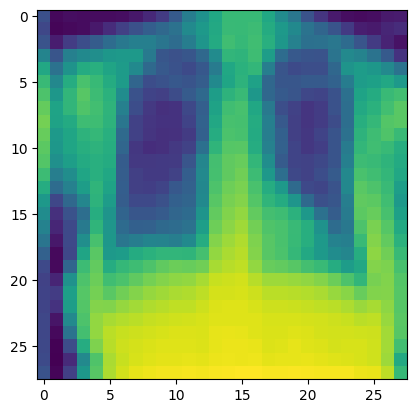

In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
ar = X_train[0]
plt.imshow(ar)

In [18]:
print(y_train.shape)
print(np.sum(y_train,axis=1)  )

(78468, 14)
[0 0 0 ... 3 0 0]


In [19]:
SEED = 123
set_all_seeds(SEED)

# create ImageDataset for train and test sets
trainSet = ImageDataset(X_train, y_train)
evalSet = ImageDataset(X_val, y_val)
testSet = ImageDataset(X_test, y_test, mode='test')
# sampler = DualSampler(trainSet, batch_size, sampling_rate=sampling_rate)
# define batch size
batch_size = 64

# create DataLoader for train and test sets
trainloader =  torch.utils.data.DataLoader(trainSet, batch_size=batch_size, num_workers=2, shuffle=True)
evalloader =  torch.utils.data.DataLoader(evalSet, batch_size=batch_size, num_workers=2, shuffle=False)
testloader =  torch.utils.data.DataLoader(testSet, batch_size=batch_size, num_workers=2, shuffle=False)


In [32]:
# paramaters

# BATCH_SIZE = 32
lr = 0.1
epoch_decay = 2e-3
weight_decay = 1e-5
margin = 1.0
total_epochs = 10

# model
model = resnet18(pretrained=True, last_activation=None, activations='relu', num_classes=14)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model = model.cuda()
lr=0.1
# define loss & optimizer
loss_fn = AUCM_MultiLabel(num_classes=14)
optimizer = PESG(model, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 margin=margin, 
                 momentum = 0.9,
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

# scheduler1 =  ReduceLROnPlateau(optimizer, 'min', patience=2)

# model

In [35]:
batch_size

64

In [33]:
# training
print ('Start Training')
print ('-'*30)

best_val_auc = 0 
# ckpt =  torch.load("chest_model.pt")
# model.load_state_dict(ckpt)
for epoch in range(total_epochs):
    if (epoch % 2 == 0) and (epoch != 0):
        optimizer.update_regularizer(decay_factor=2)   
        torch.save(model.state_dict(), "Epoch: {}".format(epoch))

    for idx, (data, targets, _) in enumerate(trainloader):
      train_data, train_labels = data, targets
      train_data, train_labels  = train_data.cuda(), train_labels.cuda()
      y_pred = model(train_data)
      y_pred = torch.sigmoid(y_pred)
      loss = loss_fn(y_pred, train_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # scheduler1.step(loss)
      # torch.save(model.state_dict(), "Epoch: {}".format(epoch))
      # print("Saving model for epoch number: {}".format(epoch))

      # validation  
      if idx % 200 == 0:
         model.eval()
         with torch.no_grad():    
              test_pred = []
              test_true = [] 
              for jdx, (data, targets, _) in enumerate(testloader):
                  test_data, test_labels = data, targets
                  test_data = test_data.cuda()
                  y_pred = model(test_data)
                  y_pred = torch.sigmoid(y_pred)
                  test_pred.append(y_pred.cpu().detach().numpy())
                  test_true.append(test_labels.numpy())
            
              test_true = np.concatenate(test_true)
              test_pred = np.concatenate(test_pred)
              val_auc_mean = np.mean(auc_roc_score(test_true, test_pred))
#               print(val_auc_mean)
#               val_auc_mean=val_auc_mean
#               model.train()

              if best_val_auc < val_auc_mean:
                 best_val_auc = val_auc_mean
                 torch.save(model.state_dict(), 'chest_model.pt')

              print ('Epoch=%s, BatchID=%s, Val_AUC=%.4f, Best_Val_AUC=%.4f'%(epoch, idx, val_auc_mean, best_val_auc))

Start Training
------------------------------
Epoch=0, BatchID=0, Val_AUC=0.4850, Best_Val_AUC=0.4850
Epoch=0, BatchID=100, Val_AUC=0.5484, Best_Val_AUC=0.5484
Epoch=0, BatchID=200, Val_AUC=0.5674, Best_Val_AUC=0.5674
Epoch=0, BatchID=300, Val_AUC=0.5652, Best_Val_AUC=0.5674
Epoch=0, BatchID=400, Val_AUC=0.5697, Best_Val_AUC=0.5697
Epoch=0, BatchID=500, Val_AUC=0.5689, Best_Val_AUC=0.5697
Epoch=0, BatchID=600, Val_AUC=0.5708, Best_Val_AUC=0.5708
Epoch=0, BatchID=700, Val_AUC=0.5687, Best_Val_AUC=0.5708
Epoch=0, BatchID=800, Val_AUC=0.5753, Best_Val_AUC=0.5753
Epoch=0, BatchID=900, Val_AUC=0.5682, Best_Val_AUC=0.5753
Epoch=0, BatchID=1000, Val_AUC=0.5808, Best_Val_AUC=0.5808
Epoch=0, BatchID=1100, Val_AUC=0.5794, Best_Val_AUC=0.5808
Epoch=0, BatchID=1200, Val_AUC=0.5751, Best_Val_AUC=0.5808
Reducing learning rate to 0.05000 @ T=1227!
Updating regularizer @ T=1227!
Epoch=1, BatchID=0, Val_AUC=0.5755, Best_Val_AUC=0.5808
Epoch=1, BatchID=100, Val_AUC=0.5845, Best_Val_AUC=0.5845
Epoch=1, B

In [30]:
# print(test_pred.shape)
# print(test_pred)
# print(auc_roc_score(test_true, test_pred))

[0.7214766909773109, 0.7563425895564792, 0.7862825989668678, 0.6523789458422253, 0.6673301592431908, 0.5975096952584035, 0.6748446339834742, 0.7509238020452583, 0.7528834646748148, 0.8408012856461109, 0.7280172010542582, 0.7220995226104804, 0.6723821261241714, 0.7998643162324999]


In [34]:
# Testing
ckpt =  torch.load("chest_model.pt")
model.load_state_dict(ckpt)
model.eval()
with torch.no_grad():    
    test_pred = []
    test_true = [] 
    for jdx, (data, targets, _) in enumerate(testloader):
        test_data, test_labels = data, targets
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_pred = torch.sigmoid(y_pred)
        test_pred.append(y_pred.cpu().detach().numpy())
        test_true.append(test_labels.numpy())

    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    test_auc_mean = auc_roc_score(test_true, test_pred)
    print(test_auc_mean)

print ('Test result   ::::::::   Test_AUC = %.4f'%(np.mean(test_auc_mean)))

[0.6746740032202209, 0.6733546523541745, 0.7461971985147382, 0.6403131822513628, 0.5929240787472703, 0.5768583954387285, 0.6654421362841237, 0.660956797771913, 0.7426972501490327, 0.8023175057673742, 0.6446327445158825, 0.6994129443125664, 0.616350933687347, 0.6900317091688625]
Test result   ::::::::   Test_AUC = 0.6733
